In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

/home/sihun.cha/miniconda3/envs/hallo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


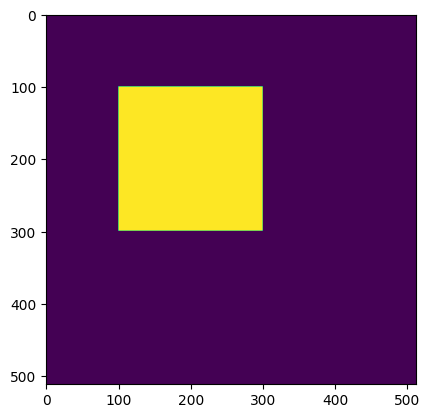

In [2]:
image =  torch.zeros(2,1,512,512)
image[:,:,100:300,100:300]=1
plt.imshow(image.permute(0,2,3,1)[0].numpy())

In [34]:
%load_ext autoreload
%autoreload 2

from hallo.models.face_locator import FaceLocator_EMO

class FaceLocator(nn.Module):
    def __init__(self, in_channel=1, out_channel=4):
        super(FaceLocator, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channel, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Define the final convolutional layer that outputs a single channel (mask)
        self.final_conv = nn.Conv2d(64, out_channel, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, images):
        # Forward pass through the convolutional layers
        # Assert that images are of the correct type (floating-point)
        assert images.dtype == torch.float32, 'Images must be of type torch.float32'
        # Assert that images have 4 dimensions [B, C, H, W]
        assert images.ndim == 4, 'Images must have 4 dimensions [B, C, H, W]'

        x = F.relu(self.conv1(images))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Shape after pooling: (B, 64, H/8, W/8)
        

        assert x.size(1) == 64, f"Input to final conv layer has {x.size(1)} channels, expected 64."

        # Pass through the final convolutional layer to get a single channel output
        logits = self.final_conv(x)  # Output logits directly, Shape: (B, 1, H/8, W/8)
        
        # No sigmoid or thresholding here because BCEWithLogitsLoss will handle it

        # Upsample logits to the size of the original image
        # logits = F.interpolate(logits, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
        
        return logits

# def normalize(v):
#     norm = np.linalg.norm(v)
#     if norm == 0: 
#        return v
#     return v / norm
def normalize(V):
    V = (V - (V.max(0).max(0) + V.min(0).min(0)) *0.5) / max(V.max(0).max(0) - V.min(0).min(0))
    V = V + 0.5
    return V

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([2, 4, 64, 64])


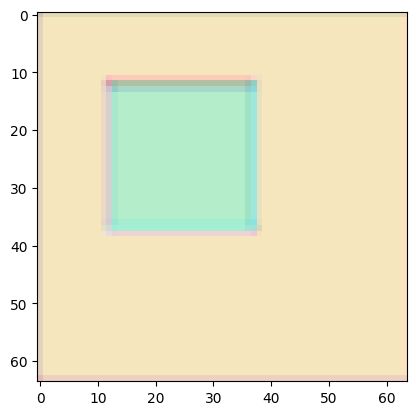

In [25]:
foo = FaceLocator()
output = foo(image)
print(output.shape)

plt.imshow(
    normalize(output[0].detach().numpy().transpose(1,2,0))
)

In [41]:
foo = FaceLocator_EMO(1,4)
output = foo(image)
print(output.shape)

torch.Size([2, 4, 64, 64])


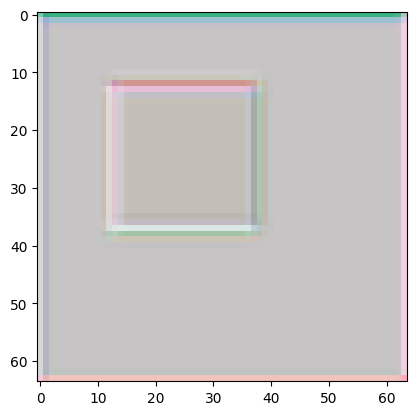

In [42]:

plt.imshow(
    normalize(output[0].detach().numpy().transpose(1,2,0))
)